In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
X, y= [], []
for file in os.listdir('./Data'):
    for image in os.listdir('./Data/'+str(file)):
        img = cv2.imread('./Data/'+str(file)+str('/')+str(image))
        X.append(img)
        y.append(file)
X = np.array(X)
y = np.array(y)

In [13]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model,load_model
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D, Activation
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.callbacks import ReduceLROnPlateau, EarlyStopping ,ModelCheckpoint, Callback, TensorBoard
from keras.optimizers import SGD,Adam
from keras.applications import ResNet50
from keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

## Normalization

In [14]:
X_scaled = X/255
X_scaled[0][158][25]

array([0.72156863, 0.72156863, 0.72156863])

## one hot encoding

In [15]:
ohe = LabelEncoder()

y_ohe = ohe.fit_transform(y)

pd.DataFrame(y_ohe).value_counts()


1    913
0    901
3    844
2    438
dtype: int64

In [16]:
pd.DataFrame(y).value_counts()

meningioma_tumor    913
glioma_tumor        901
pituitary_tumor     844
normal              438
dtype: int64

In [17]:
y_cat = keras.utils.to_categorical(y_ohe, num_classes=4)
y_cat

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=123)

In [55]:
# #ResNet50

# # Callbacks--> Stop training automatically once the model performance stop improving
learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5, restore_best_weights=True)


resnet50 = ResNet50(input_shape=(256,256,3), weights='imagenet', include_top=False)

for layer in resnet50.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(resnet50.output)

prediction = keras.layers.Dense(4, activation='softmax')(x)

model3 = keras.Model(inputs=resnet50.input, outputs=prediction)

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(X_train,y_train, epochs=15, batch_size=32,callbacks=[Early_Stopping,learning_rate_reduction])

Epoch 1/15
78/78 [==============================] - 176s 2s/step - loss: 3.9412 - accuracy: 0.3708 - lr: 0.0010
Epoch 2/15
78/78 [==============================] - 154s 2s/step - loss: 1.4497 - accuracy: 0.5085 - lr: 0.0010
Epoch 3/15
78/78 [==============================] - 154s 2s/step - loss: 1.3704 - accuracy: 0.5517 - lr: 0.0010
Epoch 4/15
78/78 [==============================] - 155s 2s/step - loss: 1.1094 - accuracy: 0.6183 - lr: 0.0010
Epoch 5/15
78/78 [==============================] - 153s 2s/step - loss: 1.3643 - accuracy: 0.6042 - lr: 0.0010
Epoch 6/15
78/78 [==============================] - 153s 2s/step - loss: 1.0022 - accuracy: 0.6668 - lr: 0.0010
Epoch 7/15
78/78 [==============================] - 153s 2s/step - loss: 0.9325 - accuracy: 0.6729 - lr: 0.0010
Epoch 8/15
78/78 [==============================] - 244s 3s/step - loss: 0.7027 - accuracy: 0.7173 - lr: 0.0010
Epoch 9/15
78/78 [==============================] - 439s 6s/step - loss: 1.3483 - accuracy: 0.6236 - lr:

In [57]:
y_pred = model3.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 144s 7s/step


In [59]:
y_true = np.argmax(y_test, axis=1)
accuracy_score(y_true,y_predicted)

0.667741935483871

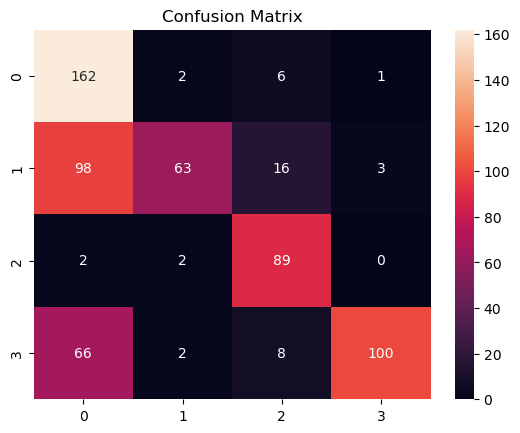

In [60]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

In [61]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.49      0.95      0.65       171
           1       0.91      0.35      0.51       180
           2       0.75      0.96      0.84        93
           3       0.96      0.57      0.71       176

    accuracy                           0.67       620
   macro avg       0.78      0.71      0.68       620
weighted avg       0.79      0.67      0.65       620



In [31]:
# #implementing denseNet

learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5, restore_best_weights=True)
densenet121 = DenseNet121(input_shape=(256,256,3), weights='imagenet', include_top=False)

for layer in densenet121.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(densenet121.output)

prediction = keras.layers.Dense(4, activation='softmax')(x)

model1 = keras.Model(inputs=densenet121.input, outputs=prediction)

model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

model1.fit(X_train,y_train, epochs=15, batch_size=32,callbacks=[Early_Stopping,learning_rate_reduction])

Epoch 1/15
78/78 [==============================] - 114s 1s/step - loss: 3.7445 - accuracy: 0.6789 - lr: 0.0010
Epoch 2/15
78/78 [==============================] - 105s 1s/step - loss: 0.5077 - accuracy: 0.8837 - lr: 0.0010
Epoch 3/15
78/78 [==============================] - 108s 1s/step - loss: 0.3484 - accuracy: 0.9285 - lr: 0.0010
Epoch 4/15
78/78 [==============================] - 105s 1s/step - loss: 0.1362 - accuracy: 0.9608 - lr: 0.0010
Epoch 5/15
78/78 [==============================] - 105s 1s/step - loss: 0.1398 - accuracy: 0.9624 - lr: 0.0010
Epoch 6/15
78/78 [==============================] - 105s 1s/step - loss: 0.1045 - accuracy: 0.9729 - lr: 0.0010
Epoch 7/15
78/78 [==============================] - 105s 1s/step - loss: 0.0576 - accuracy: 0.9838 - lr: 0.0010
Epoch 8/15
78/78 [==============================] - 108s 1s/step - loss: 0.0119 - accuracy: 0.9952 - lr: 0.0010
Epoch 9/15
78/78 [==============================] - 106s 1s/step - loss: 0.0567 - accuracy: 0.9859 - lr:

In [32]:
y_pred = model1.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 48s 2s/step


In [33]:
y_true = np.argmax(y_test, axis=1)
accuracy_score(y_true,y_predicted)

0.9306451612903226

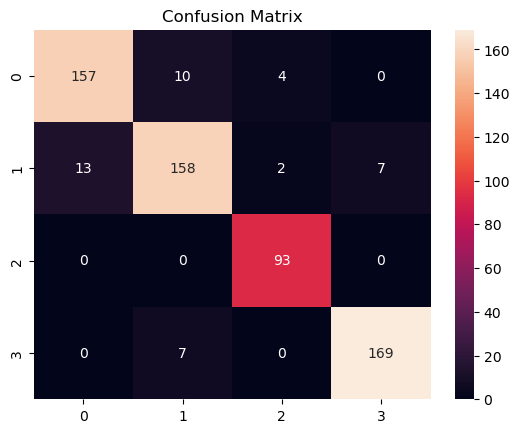

In [34]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

In [35]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       171
           1       0.90      0.88      0.89       180
           2       0.94      1.00      0.97        93
           3       0.96      0.96      0.96       176

    accuracy                           0.93       620
   macro avg       0.93      0.94      0.93       620
weighted avg       0.93      0.93      0.93       620



In [21]:
# #mobilenet code

learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5, restore_best_weights=True)
mobilenet = MobileNetV2(input_shape=(256,256,3), weights='imagenet', include_top=False)

for layer in mobilenet.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(mobilenet.output)

prediction = keras.layers.Dense(4, activation='softmax')(x)

model2 = keras.Model(inputs=mobilenet.input, outputs=prediction)

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(X_train,y_train, epochs=15, batch_size=32,callbacks=[Early_Stopping,learning_rate_reduction])

9406464/9406464 [==============================] - 2s 0us/step
Epoch 1/15
78/78 [==============================] - 176s 2s/step - loss: 3.0162 - accuracy: 0.7468 - lr: 0.0010
Epoch 2/15
78/78 [==============================] - 171s 2s/step - loss: 0.4324 - accuracy: 0.9342 - lr: 0.0010
Epoch 3/15
78/78 [==============================] - 168s 2s/step - loss: 0.1527 - accuracy: 0.9721 - lr: 0.0010
Epoch 4/15
78/78 [==============================] - 166s 2s/step - loss: 0.0840 - accuracy: 0.9822 - lr: 0.0010
Epoch 5/15
78/78 [==============================] - 156s 2s/step - loss: 0.0534 - accuracy: 0.9887 - lr: 0.0010
Epoch 6/15
78/78 [==============================] - 162s 2s/step - loss: 0.0558 - accuracy: 0.9826 - lr: 0.0010
Epoch 7/15
78/78 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9891
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
78/78 [==============================] - 170s 2s/step - loss: 0.0661 - accuracy: 0.9891 - lr: 0

In [22]:
y_pred = model2.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 47s 2s/step


In [23]:
y_true = np.argmax(y_test, axis=1)
accuracy_score(y_true,y_predicted)

0.9193548387096774

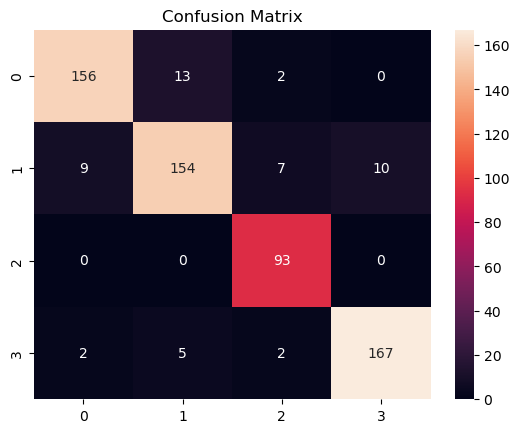

In [24]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

In [25]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       171
           1       0.90      0.86      0.88       180
           2       0.89      1.00      0.94        93
           3       0.94      0.95      0.95       176

    accuracy                           0.92       620
   macro avg       0.92      0.93      0.92       620
weighted avg       0.92      0.92      0.92       620



In [26]:
# #Inception net code

learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5, restore_best_weights=True)
inceptionv3 = InceptionV3(input_shape=(256,256,3), weights='imagenet', include_top=False)

for layer in inceptionv3.layers:
    layer.trainable = False
    
x = keras.layers.Flatten()(inceptionv3.output)

prediction = keras.layers.Dense(4, activation='softmax')(x)

model4 = keras.Model(inputs=inceptionv3.input, outputs=prediction)

model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model4.fit(X_train,y_train, epochs=15, batch_size=32,callbacks=[Early_Stopping,learning_rate_reduction])

Epoch 1/15
78/78 [==============================] - 364s 4s/step - loss: 3.2009 - accuracy: 0.6793 - lr: 0.0010
Epoch 2/15
78/78 [==============================] - 312s 4s/step - loss: 0.7077 - accuracy: 0.8877 - lr: 0.0010
Epoch 3/15
78/78 [==============================] - 310s 4s/step - loss: 0.1553 - accuracy: 0.9519 - lr: 0.0010
Epoch 4/15
78/78 [==============================] - 312s 4s/step - loss: 0.1534 - accuracy: 0.9596 - lr: 0.0010
Epoch 5/15
78/78 [==============================] - 310s 4s/step - loss: 0.0846 - accuracy: 0.9770 - lr: 0.0010
Epoch 6/15
78/78 [==============================] - 315s 4s/step - loss: 0.1454 - accuracy: 0.9709 - lr: 0.0010
Epoch 7/15
78/78 [==============================] - 314s 4s/step - loss: 0.0730 - accuracy: 0.9814 - lr: 0.0010
Epoch 8/15
78/78 [==============================] - 240s 3s/step - loss: 0.0324 - accuracy: 0.9923 - lr: 0.0010
Epoch 9/15
78/78 [==============================] - 84s 1s/step - loss: 0.0187 - accuracy: 0.9952 - lr: 

In [27]:
y_pred = model4.predict(X_test)
y_predicted = np.argmax(y_pred, axis=1)

20/20 [==============================] - 23s 1s/step


In [28]:
y_true = np.argmax(y_test, axis=1)
accuracy_score(y_true,y_predicted)

0.8935483870967742

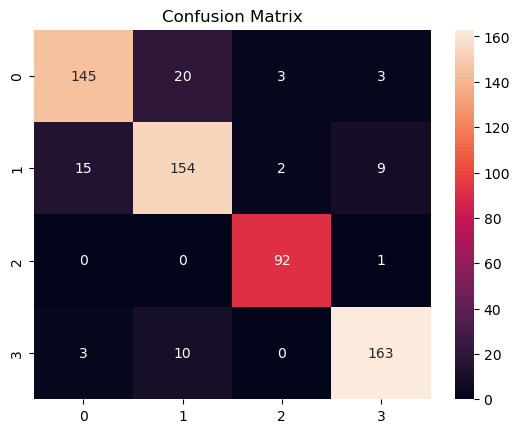

In [29]:
cm = confusion_matrix(y_true, y_predicted)

sns.heatmap(cm, annot=True,fmt=".0f")
plt.title("Confusion Matrix")
plt.show()

In [30]:
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       171
           1       0.84      0.86      0.85       180
           2       0.95      0.99      0.97        93
           3       0.93      0.93      0.93       176

    accuracy                           0.89       620
   macro avg       0.90      0.90      0.90       620
weighted avg       0.89      0.89      0.89       620

